In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
kernel_size = 3
in_channels = 2
out_channels = 2

In [3]:
# Kernel definitions
k_edge_detector = np.array([
    [-1, -1, -1],
    [-1,  8, -1],
    [-1, -1, -1]
])
k_blur = np.array([
    [1, 2, 1],
    [2, 4, 2],
    [1, 2, 1]
])
k_sharpen = np.array([
    [0, -1, 0],
    [-1, 5, -1],
    [0, -1, 0]
])
k_identity = np.array([
    [0, 0, 0],
    [0, 1, 0],
    [0, 0, 0]
])
kernels_channel_indexed = {
    0: [k_edge_detector, k_blur],
    1: [k_sharpen, k_identity]
}

In [4]:
def get_kernel_weights(
    input_channel: int,
    kernel_index: int = 0,
    kernel_memory: dict = kernels_channel_indexed
):
    channel_kernels = kernel_memory[input_channel]

    weights = [0] * len(channel_kernels)

    for idx, kernel in enumerate(channel_kernels):
        
        weights[idx] = kernel.flatten()[kernel_index]

    return weights

get_kernel_weights(input_channel=0, kernel_index=0)

[-1, 1]

In [5]:
def convert_to_torch_weight(kernels_dict):
    input_channels = len(kernels_dict)
    output_channels = len(kernels_dict[0])
    
    torch_weights = torch.zeros(output_channels, input_channels, kernel_size, kernel_size)

    for input_channel in range(input_channels):
        for output_channel in range(output_channels):
            kernel = kernels_dict[input_channel][output_channel]
            torch_weights[output_channel, input_channel, :, :] = torch.from_numpy(kernel.astype(np.float32))

    return torch_weights 

convert_to_torch_weight(kernels_channel_indexed)

tensor([[[[-1., -1., -1.],
          [-1.,  8., -1.],
          [-1., -1., -1.]],

         [[ 0., -1.,  0.],
          [-1.,  5., -1.],
          [ 0., -1.,  0.]]],


        [[[ 1.,  2.,  1.],
          [ 2.,  4.,  2.],
          [ 1.,  2.,  1.]],

         [[ 0.,  0.,  0.],
          [ 0.,  1.,  0.],
          [ 0.,  0.,  0.]]]])

In [6]:
def create_torch_layer(kernels_dict):
    input_channels = len(kernels_dict)
    output_channels = len(kernels_dict[0])

    conv_layer = nn.Conv2d(
        in_channels=input_channels,
        out_channels=output_channels,
        kernel_size=kernel_size,
        padding=1,
        bias=False,
        padding_mode='zeros'
    )

    kernel_weights = convert_to_torch_weight(kernels_dict)
    conv_layer.weight.data = kernel_weights
    return conv_layer

conv = create_torch_layer(kernels_channel_indexed)

dx: -1, dy: -1 => kernel_position: 0 => kernel vector weights: [-1  1]
[-1.  1.]
dx: -1, dy: 0 => kernel_position: 1 => kernel vector weights: [-1  2]
[-1.  2.]
dx: -1, dy: 1 => kernel_position: 2 => kernel vector weights: [-1  1]
[-1.  1.]
dx: 0, dy: -1 => kernel_position: 3 => kernel vector weights: [-1  2]
[-1.  2.]
dx: 0, dy: 0 => kernel_position: 4 => kernel vector weights: [8 4]
[8. 4.]
dx: 0, dy: 1 => kernel_position: 5 => kernel vector weights: [-1  2]
[-1.  2.]
dx: 1, dy: -1 => kernel_position: 6 => kernel vector weights: [-1  1]
[-1.  1.]
dx: 1, dy: 0 => kernel_position: 7 => kernel vector weights: [-1  2]
[-1.  2.]
dx: 1, dy: 1 => kernel_position: 8 => kernel vector weights: [-1  1]
[-1.  1.]
(8, 8, 2)


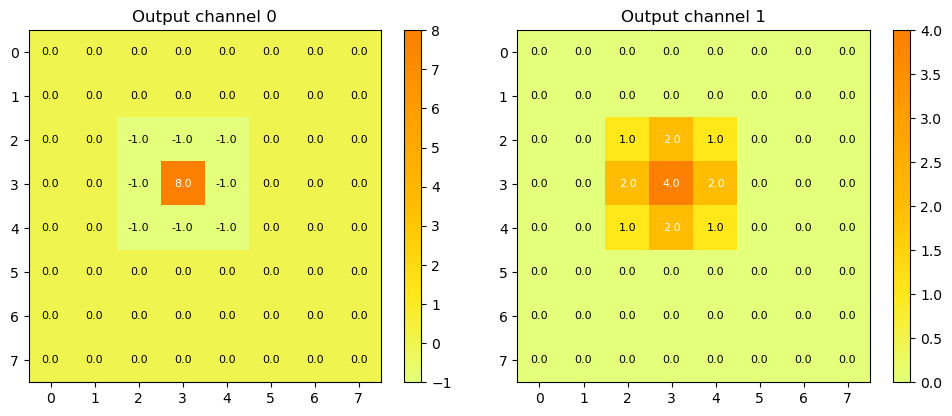

In [ ]:
def sim_one_channel(
    in_channel_index: int,
    event_coord: tuple[int, int],
    image_dimensions: tuple[int, int],
    kernel_size: int = kernel_size,
    out_channels: int = out_channels,
):

    x, y = event_coord
    img_w, img_h = image_dimensions
    out_feature_maps = np.zeros((img_h, img_w, out_channels), dtype=np.float32)

    kernel_offset = kernel_size // 2
    for dx in range(-kernel_offset, kernel_offset+1):
        for dy in range(-kernel_offset, kernel_offset+1):
            kernel_position = (dx + kernel_offset) * kernel_size + (dy + kernel_offset)
            kernel_weights = np.array(get_kernel_weights(in_channel_index, kernel_position))
            #print(f"dx: {dx}, dy: {dy} => kernel_position: {kernel_position} => kernel vector weights: {kernel_weights}")

            #print(out_feature_maps[y + dy, x + dx, :]+ kernel_weights)
            if 0 <= x + dx < img_w and 0 <= y + dy < img_h:
                out_feature_maps[y + dy, x + dx, :] += kernel_weights
            

    return out_feature_maps

result = sim_one_channel(
    in_channel_index=0,
    event_coord=(3, 3),
    image_dimensions=(8,8),
    kernel_size=kernel_size,
    out_channels=out_channels
)
print(result.shape)
# Plot each output channel
fig, axes = plt.subplots(1, out_channels, figsize=(5 * out_channels, 4))
if out_channels == 1:
    axes = [axes]
for ch in range(out_channels):
    ax = axes[ch]
    im = ax.imshow(result[:, :, ch], cmap='Wistia')
    ax.set_title(f"Output channel {ch}")
    fig.colorbar(im, ax=ax)
    # Print values on each cell
    for i in range(result.shape[0]):
        for j in range(result.shape[1]):
            val = result[i, j, ch]
            ax.text(j, i, f"{val:.1f}", ha='center', va='center', color='white' if abs(val) > 1 else 'black', fontsize=8)
plt.tight_layout()
plt.show()

In [ ]:
# Make an input image for torch conv layer
event_coord = (3, 3)  # Example event coordinate
N, C_in, H, W = 1, in_channels, 8, 8
input_image = torch.zeros((N, C_in, H, W), dtype=torch.float32)
input_image[0, 0, event_coord[1], event_coord[0]] = 1.0  # Set the event at the specified coordinate


Input image shape: torch.Size([1, 2, 8, 8])
